In [1]:
# utils
import os
from dotenv import load_dotenv
import copy
import time
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',None) # 또는 숫자 지정
pd.set_option('display.max_columns',None)

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일 저장 경로
    name='NanumBarunGothic' # 별칭
)
fm.fontManager.ttflist.insert(0,fe)
plt.rcParams.update({'font.family' : 'NanumBarunGothic'}) # 한글 패치
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False # 음수 부호 안 깨지게

# Machine Learning
from sklearn.metrics import accuracy_score, f1_score

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

# Image Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
from augraphy import *

### random seed 고정 함수
def set_seed(seed: int = 42):
    """모든 랜덤 시드를 고정합니다.

    :param int seed: 고정할 시드 값, defaults to 42
    """
    random.seed(seed)
    np.random.seed(seed)

    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 멀티 GPU용
        
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except ImportError:
        pass  # torch가 설치되어 있지 않으면 무시
print("현재 jupyter notebook의 실행 경로:", os.getcwd())

project_root = '/data/ephemeral/home/upstageailab-cv-classification-cv_5'
data_dir = os.path.join(project_root, 'data')
print("⚙️ Data Directory Path:", data_dir)

device = 'cpu'
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
print("⚙️ Device :",device)


현재 jupyter notebook의 실행 경로: /data/ephemeral/home/upstageailab-cv-classification-cv_5/codes/practice
⚙️ Data Directory Path: /data/ephemeral/home/upstageailab-cv-classification-cv_5/data
⚙️ Device : cuda


In [2]:
CFG = {
    'model_name': 'resnetrs101.tf_in1k', # timm model name
    'pretrained': True, # timm pretrained 가중치 사용 여부
    'fine_tuning': "full", # fine-tuning 방법론
    # full : pretrained=True, pretrained가중치를 전부 재학습시킨다. 
    # head : pretrained=True, model backbone 부분은 freeze하고 head 부분을 재학습시킨다.
    # custom : pretrained=True, backbone에서도 일부분을 재학습시킨다.
    # scratch : pretrained=False, 모델 구조만 사용하고 모든 가중치를 처음부터 학습시킨다.
    # Loss Function
    'criterion': 'CrossEntropyLoss',
    # optimizer name: SGD, RMSprop, Momentum, NAG, Adam, AdamW, NAdam, RAdam, Adafactor
    # reference : https://www.notion.so/skier-song9/Pytorch-9cfee0520ed6468a94b024ea35e48018?source=copy_link#217c8d3f60f58044beeac55596433dc6
    'optimizer_name': 'Adam', 
    'lr': 1e-2, # learning rate
    'weight_decay': 1e-4, # weight decay ratio
    # scheduler_name : StepLR, ExponentialLR, CosineAnnealingLR, OneCycleLR, ReduceLROnPlateau
    # reference : https://www.notion.so/skier-song9/Pytorch-9cfee0520ed6468a94b024ea35e48018?source=copy_link#1d2c8d3f60f58026b71ad399ead029a9
    'scheduler_name': 'ExponentialLR',
    
    # 기타 변수들
    'random_seed': 256, 
    'n_folds': 5, # validation set, cross-validation 시 fold의 개수
    'val_split_ratio': 0.15, # train-val split 비율
    'stratify': True, # validation set 분할 시 stratify 전략 사용 여부
    'image_size': 600, # 만약 multi-scale train/test 시 None으로 설정

    # normalization mean, std
    # full file tuning 시 0.5가 유리
    # pre-trained 모델 사용 시 pre-trained 모델의 mean, std를 사용
    'norm_mean': [0.5, 0.5, 0.5],
    'norm_std': [0.5, 0.5, 0.5],

    # 적용하는 기법들 명시
    'augmentation': {},

    # 모델에 대한 hyperparameters
    'model_layer': {}, # model layer의 filter size, activation function, pooling layer 등 변경 시 작성
    'dropout': None, # model layer에서 dropout 비율 변경 시 작성

    # 학습 시 hyperparameters
    'epochs': 10000, # max epoch
    'patience': 50, # early stopping patience
    'batch_size': 64,

    # device
    'device': device # device name
}
if CFG['patience'] < 5:
    raise ValueError("Ealry stopping patience must be larger than 5!")
# transform dictionary into namespace
from types import SimpleNamespace
CFG = SimpleNamespace(**CFG)

# set random seed
set_seed(CFG.random_seed)

In [3]:
meta = pd.read_csv(os.path.join(data_dir, 'meta.csv'))
meta_dict = zip(meta['target'], meta['class_name'])
meta_dict = dict(meta_dict)
meta_dict[-1] = "None"

In [4]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    # def __init__(self, csv, path, transform=None):
    def __init__(self, df:pd.DataFrame, path, transform=None, transform_factors=dict()):
        """
        :param pd.DataFrame df: train-val을 위해서는 pandas.Dataframe으로 받아야 함.
        :param str path: 이미지 데이터 디렉토리 경로
        :param _type_ transform: 이미지 변형, defaults to None
        """
        self.df = df
        self.path = path
        self.transform = transform
        self.transform_factors = transform_factors

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df.iloc[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [5]:
# train-validation split
### TO-DO
from sklearn.model_selection import train_test_split
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
train_idx, val_idx = train_test_split(
    range(len(train_df)),
    test_size=CFG.val_split_ratio,
    stratify=train_df['target'],
    shuffle=True,
    random_state=CFG.random_seed
)
print(len(train_idx), len(val_idx))

# Create train and validation CSV files temporarily
train_subset = train_df.iloc[train_idx].reset_index(drop=True)
val_subset = train_df.iloc[val_idx].reset_index(drop=True)

test_df = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))
import random
def get_random_index(df, n=3):
    return random.sample(range(len(df)), n)
def visualize_by_index(dataset, indexs):
    global meta_dict
    n = len(indexs)
    plt.figure(figsize=(4*n,3))
    for i in range(n):
        image = dataset[indexs[i]]  # transform은 dataset 내부에서 적용됨
        target = -1
        if isinstance(image, tuple):
            target = image[1]
            image = image[0]  # image, label tuple이면 image만 추출
        image = image.permute(1, 2, 0)  # CHW -> HWC
        # Normalize 역변환 (선택)
        # image = image * torch.tensor(CFG.norm_std) + torch.tensor(CFG.norm_mean)
        # image = image.clip(0, 1)  # 정규화 범위 보정
        image = image.numpy()

        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Index {indexs[i]} - {meta_dict[target]}")
    plt.tight_layout()
    plt.show()
train_idxs = get_random_index(train_subset, n=3)
val_idxs = get_random_index(val_subset, n=3)
print(train_idx)
print(val_idxs)

1334 236
[5, 1421, 505, 175, 1093, 1318, 772, 1556, 489, 1170, 519, 1081, 613, 1301, 127, 1059, 562, 595, 260, 38, 847, 99, 400, 1211, 36, 1516, 643, 1158, 1558, 739, 374, 1492, 1522, 19, 1007, 1098, 768, 110, 98, 1265, 628, 124, 415, 848, 305, 1497, 354, 296, 17, 602, 1010, 1039, 202, 293, 567, 27, 763, 360, 468, 667, 1398, 610, 4, 1245, 238, 559, 90, 330, 517, 522, 1434, 1346, 52, 954, 876, 1387, 815, 113, 816, 1278, 936, 394, 1144, 905, 396, 324, 638, 425, 1012, 1086, 1131, 921, 945, 1505, 722, 1263, 413, 732, 1337, 370, 1284, 378, 985, 419, 1141, 1478, 1399, 1538, 708, 1395, 443, 196, 1523, 172, 136, 1447, 252, 1037, 108, 1223, 998, 1240, 1276, 615, 411, 1441, 808, 604, 1569, 1127, 844, 119, 923, 269, 484, 151, 830, 810, 770, 1393, 1115, 1373, 798, 1474, 946, 310, 1286, 764, 333, 380, 1181, 198, 1290, 1414, 1392, 875, 225, 748, 276, 272, 1107, 637, 1452, 1359, 820, 922, 1068, 1443, 1308, 560, 944, 1159, 686, 331, 1483, 438, 1155, 97, 1273, 1407, 953, 191, 787, 1035, 826, 240, 482, 

## Test dataset 분포 분석

In [6]:
from PIL import Image, ImageStat, ImageFilter
import cv2
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')
import math

import pywt

In [7]:
test_df = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
# EDA functions
def calculate_brightness(image_path):
    """주어진 이미지 경로의 이미지 평균 밝기를 계산합니다."""
    with Image.open(image_path).convert('L') as img: # 이미지를 열고 흑백(L) 모드로 변환합니다. < 밝기(Luminance) 측정의 표준적인 접근 방식
        stat = ImageStat.Stat(img) # 이미지 통계를 계산하기 위한 ImageStat 객체를 생성합니다.
        return stat.median[0] # 흑백 이미지의 중앙값을 반환합니다 (밝기). > 이상치에 강건하도록 더 주요 밝기를 추출

def calculate_color_channel_distributions(image_path):
    """
    컬러 이미지의 각 RGB 채널별 평균 픽셀 값을 계산합니다.

    :param image_path: 분석할 컬러 이미지 파일 경로.
    :return: (red_mean, green_mean, blue_mean) 튜플, 이미지 로드 실패 시 None.
    """
    with Image.open(image_path).convert('RGB') as img: # 이미지를 RGB 모드로 엽니다.
        img_array = np.array(img) # 이미지를 NumPy 배열로 변환합니다.
        
        # 각 채널의 평균 픽셀 값을 계산합니다.
        red_mean = img_array[:, :, 0].mean() # 빨강 채널 (0번째)
        green_mean = img_array[:, :, 1].mean() # 초록 채널 (1번째)
        blue_mean = img_array[:, :, 2].mean() # 파랑 채널 (2번째)
        
        return red_mean, green_mean, blue_mean

def calculate_contrast(image_path):
    """
    주어진 이미지 경로의 이미지 대비를 계산합니다. (픽셀 강도의 표준 편차 사용)
    """
    with Image.open(image_path).convert('L') as img: # 이미지를 열고 흑백(L) 모드로 변환합니다.
        img_array = np.array(img)
        return img_array.std() # 픽셀 값의 표준 편차를 반환하여 대비를 나타냅니다.

def calculate_blurriness(image_path):
    """
    라플라시안 분산 방법을 사용하여 이미지의 흐림 정도를 계산합니다.
    > 
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("이미지를 불러오지 못했습니다.")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 이미지를 BGR에서 회색조로 변환합니다.
    return cv2.Laplacian(gray, cv2.CV_64F).var() # 라플라시안 필터를 적용하고 그 결과의 분산을 반환합니다.

# def calculate_noise(image_path):
#     """
#     균일한 영역의 픽셀 값 분산을 분석하여 노이즈를 추정합니다(단순화된 방식).
#     이것은 매우 기본적인 근사치입니다. 더 정교한 방법들이 존재합니다.
#     """
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     if img is None:
#         raise ValueError("이미지를 불러오지 못했습니다.")
#     # For a simple estimation, we can look at the standard deviation of pixel values
#     # or a small region, but it's hard to isolate "noise" without a clean reference.
#     # A more robust method would involve frequency domain analysis or specific noise models.
#     # For simplicity, let's use the variance of a high-pass filtered image.
#     laplacian = cv2.Laplacian(img, cv2.CV_64F)
#     return np.var(laplacian)

def calculate_noise(image_path):
    """
    웨이블렛 변환을 사용하여 이미지를 다양한 주파수 대역으로 분해, 이미지의 노이즈 표준 편차를 추정합니다.
    노이즈는 주로 고주파 대역에 집중되는 경향이 있습니다. 웨이블렛 계수의 특정 통계량(예: 중앙값 절대 편차, MAD)을 분석하여 노이즈 레벨을 추정할 수 있습니다.
    (Roberts, E. A., & S. L. Tanimoto. 2005. Image Denoising using Wavelet Transforms)
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # 이미지를 회색조로 읽어옵니다.
    if img is None:
        raise ValueError("이미지를 불러오지 못했습니다.")

    # 정규화를 위해 float 타입으로 변환합니다.
    img_float = img.astype(np.float32) / 255.0

    # DWT (Discrete Wavelet Transform) 수행
    # 'db1' 웨이블렛 (Haar 웨이블렛), 1레벨 분해
    coeffs = pywt.dwt2(img_float, 'db1')
    # 각 레벨의 계수는 (cA, (cH, cV, cD)) 튜플로 반환됩니다.
    # cD (Detail Diagonal) 계수는 대각선 방향의 고주파 성분을 나타내며, 노이즈에 민감합니다.
    cH, cV, cD = coeffs[1] # 고주파 성분 계수들을 가져옵니다.

    # 노이즈 표준 편차 추정을 위한 중앙값 절대 편차 (MAD) 사용
    # 노이즈가 가우시안 분포를 따른다고 가정할 때, MAD는 표준 편차의 좋은 추정치입니다.
    # sigma_noise = median(|cD|) / 0.6745 (가우시안 노이즈의 경우)
    mad_cD = np.median(np.abs(cD))
    noise_std_dev = mad_cD / 0.6745

    return noise_std_dev

def calculate_aspect_ratio(image_path):
    """
    주어진 이미지 경로의 이미지 종횡비 (너비 / 높이)를 계산합니다.
    """
    with Image.open(image_path) as img: # 이미지를 엽니다.
        width, height = img.size # 이미지의 너비와 높이를 가져옵니다.
        return width / height # 너비를 높이로 나눈 값을 반환합니다.
    
def estimate_rotation_hough(image_path, canny_low_threshold=50, canny_high_threshold=150,
                        hough_threshold=100, min_line_length=25, max_line_gap=10):
    """
    회전(rotation) 추정합니다. 이는 매우 복잡하며 일반적으로 특징 감지
    및 호모그래피 추정 또는 딥러닝 모델이 필요합니다.
    따라서 Hough 변환을 사용하여 이미지의 직선들을 검출하고,
    수평 또는 수직선에 가까운 직선들의 평균 기울기를 통해 회전 각도를 추정합니다.

    :param image_path: 분석할 이미지 파일 경로.
    :param canny_low_threshold: Canny 엣지 검출을 위한 낮은 임계값.
    :param canny_high_threshold: Canny 엣지 검출을 위한 높은 임계값.
    :param hough_threshold: Hough 변환에서 직선으로 간주할 최소 투표 수.
    :param min_line_length: 검출할 직선의 최소 길이.
    :param max_line_gap: 직선으로 간주될 수 있는 최대 픽셀 간격.
    :return: 추정된 회전 각도 (도 Degree), 또는 직선이 충분히 검출되지 않으면 np.nan.
    """
    img = cv2.imread(image_path) # OpenCV를 사용하여 이미지를 읽어옵니다.
    if img is None: # 이미지를 읽어오지 못했을 경우
        print(f"경고: 이미지를 읽을 수 없습니다: {image_path}")
        return None # None을 반환합니다.

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 이미지를 회색조로 변환합니다.
    # Canny 엣지 검출을 적용하여 이미지의 가장자리를 찾습니다.
    # Canny는 Hough 변환 전에 노이즈를 줄이고 엣지를 명확히 하는 데 필수적입니다.
    edges = cv2.Canny(gray, canny_low_threshold, canny_high_threshold, apertureSize=3)

    # 확률적 Hough 변환 (Probabilistic Hough Transform)을 사용하여 직선을 검출합니다.
    # cv2.HoughLinesP(이미지, rho 해상도, theta 해상도, 임계값, 최소선 길이, 최대 선 간격)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, hough_threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)

    angles = [] # 검출된 직선들의 각도를 저장할 리스트

    if lines is not None: # 직선이 검출된 경우
        for line in lines: # 각 직선에 대해 반복
            x1, y1, x2, y2 = line[0] # 직선의 시작점 (x1, y1)과 끝점 (x2, y2) 좌표를 가져옵니다.
            # 직선의 각도(라디안)를 계산합니다.
            # math.atan2는 y축과 x축 변화량을 인자로 받아 정확한 각도를 계산합니다.
            angle_rad = math.atan2(y2 - y1, x2 - x1)
            angle_deg = math.degrees(angle_rad) # 라디안을 도로 변환합니다.

            # 수평선 또는 수직선에 가까운 직선만 고려합니다.
            # 0도 (수평) 또는 90도 (수직) 근처의 각도만 유효하게 간주하여 이미지 회전을 추정합니다.
            # 이는 이미지의 전반적인 기울기를 파악하는 데 도움이 됩니다.
            if -45 < angle_deg <= 45: # -45도에서 45도 사이 (주로 수평선)
                angles.append(angle_deg)
            elif (90 - 45 < angle_deg <= 90 + 45) or (-90 - 45 < angle_deg <= -90 + 45): # 45도에서 135도 사이 또는 -135도에서 -45도 사이 (주로 수직선)
                # 수직선은 0도 기준으로 90도 차이가 나므로, 90도를 빼서 수평선 기준으로 정규화합니다.
                angles.append(angle_deg - 90 if angle_deg > 0 else angle_deg + 90)

    if angles: # 유효한 각도들이 존재하면
        # 각도들의 중앙값을 사용하여 대표적인 회전 각도를 추정합니다.
        # 평균보다 중앙값이 이상치 직선의 영향을 덜 받습니다.
        median_angle = np.median(angles)
        return median_angle
    else:
        # 충분한 직선이 검출되지 않았거나, 모든 직선이 임계 범위를 벗어난 경우
        return np.nan # None을 반환합니다.

In [26]:
def visualize_distributions(df_eda, data_type="train"):
    """
    Visualizes the distributions of the calculated image properties using plt.hist.
    """
    plt.style.use('seaborn-v0_8-darkgrid') # Still use seaborn style for aesthetics

    # Figure 1: Brightness and Contrast
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Brightness
    axes[0].hist(df_eda['brightness'], bins=50, color='skyblue', edgecolor='black', density=True)
    axes[0].set_title(f'Distribution of {data_type} Image Brightness', fontsize=14)
    axes[0].set_xlabel('Brightness (0-255)', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    # Optionally add KDE using seaborn.kdeplot if desired, or manually estimate and plot
    # sns.kdeplot(df_eda['brightness'], ax=axes[0], color='blue', linewidth=2)

    # Contrast
    axes[1].hist(df_eda['contrast'], bins=50, color='salmon', edgecolor='black', density=True)
    axes[1].set_title(f'Distribution of {data_type} Image Contrast', fontsize=14)
    axes[1].set_xlabel('Contrast (Std Dev of Pixels)', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    # sns.kdeplot(df_eda['contrast'], ax=axes[1], color='red', linewidth=2)
    plt.tight_layout()
    plt.show()

    # Color Channel
    plt.figure(figsize=(10,6))
    # Red
    plt.hist(df_eda['red'].dropna(), bins=50, color='red', alpha=0.3, label='Red Channel', density=True)
    # Green
    plt.hist(df_eda['green'].dropna(), bins=50, color='green', alpha=0.3, label='Green Channel', density=True)
    # Blue
    plt.hist(df_eda['blue'].dropna(), bins=50, color='blue', alpha=0.3, label='Blue Channel', density=True)
    plt.title(f'Distribution of {data_type} Image Color Channel', fontsize=14)
    plt.xlabel('Channel Color (0-255)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Figure 2: Blurriness and Noise
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Blurriness
    axes[0].hist(df_eda['blurriness'].dropna(), bins=50, color='lightgreen', edgecolor='black', density=True)
    axes[0].set_title(f'Distribution of {data_type} Image Blurriness (Laplacian Variance)', fontsize=14)
    axes[0].set_xlabel('Blurriness', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    # sns.kdeplot(df_eda['blurriness'].dropna(), ax=axes[0], color='darkgreen', linewidth=2)

    # Noise
    axes[1].hist(df_eda['noise_estimate'].dropna(), bins=50, color='orchid', edgecolor='black', density=True)
    axes[1].set_title(f'Distribution of {data_type} Image Noise (Wavelet Transform)', fontsize=14)
    axes[1].set_xlabel('Noise Estimate', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    # sns.kdeplot(df_eda['noise_estimate'].dropna(), ax=axes[1], color='purple', linewidth=2)
    plt.tight_layout()
    plt.show()

    # Figure 3: Aspect Ratio
    plt.figure(figsize=(10, 6))
    plt.hist(df_eda['aspect_ratio'], bins=50, color='cornflowerblue', edgecolor='black', density=True)
    plt.title(f'Distribution of {data_type} Image Aspect Ratios', fontsize=14)
    plt.xlabel('Aspect Ratio (Width / Height)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.axvline(x=1.0, color='r', linestyle='--', label='1:1 Aspect Ratio')
    plt.axvline(x=4/3, color='g', linestyle=':', label='4:3 Aspect Ratio')
    plt.axvline(x=16/9, color='purple', linestyle='-.', label='16:9 Aspect Ratio')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Figure 4: Rotation/Shear (Categorical summary using plt.barh)
    plt.figure(figsize=(10, 6))
    # Blurriness
    plt.hist(df_eda['rotation_info'].dropna(), bins=36, color='lightyellow', edgecolor='black', density=True)
    plt.title(f'Distribution of {data_type} Image Rotation(Hough Transform)', fontsize=14)
    plt.xlabel('Rotation', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.tight_layout()
    plt.show()

In [27]:
image_filenames = test_df['ID'].tolist()
data = []
for image_filename in tqdm(image_filenames):
    image_path = os.path.join(data_dir,'test',image_filename)
    if not os.path.exists(image_path):
        print(f"Warning: Image not found: {image_path}")
        continue
    try:
        brightness = calculate_brightness(image_path)
        color_channel = calculate_color_channel_distributions(image_path) # RGB
        red, green, blue = color_channel
        contrast = calculate_contrast(image_path) 
        blurriness = calculate_blurriness(image_path)
        noise_estimate = calculate_noise(image_path)
        aspect_ratio = calculate_aspect_ratio(image_path)
        rotation_info = estimate_rotation_hough(image_path)

        data.append({
            'ID': image_filename,
            'brightness': brightness,
            'red': red,
            'green': green,
            'blue': blue,
            'contrast': contrast,
            'blurriness': blurriness,
            'noise_estimate': noise_estimate,
            'aspect_ratio': aspect_ratio,
            'rotation_info': rotation_info,
        })
    except Exception as e:
        print(f"Error processing {image_filename}: {e}")
test_eda_df = pd.DataFrame(data)

100%|██████████| 3140/3140 [01:24<00:00, 36.98it/s]


In [28]:
test_eda_df['noise_estimate'].describe()

count    3140.000000
mean        0.006329
std         0.005365
min         0.000000
25%         0.002907
50%         0.005814
75%         0.008721
max         0.026163
Name: noise_estimate, dtype: float64

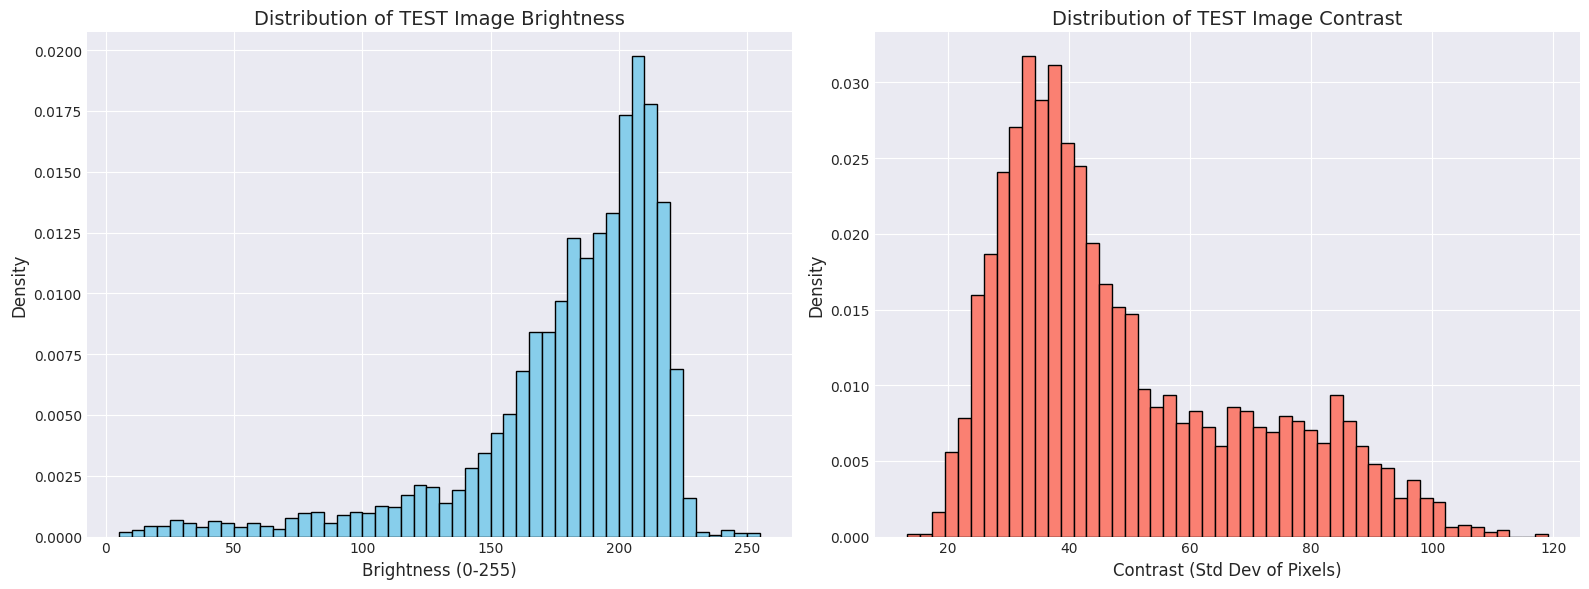

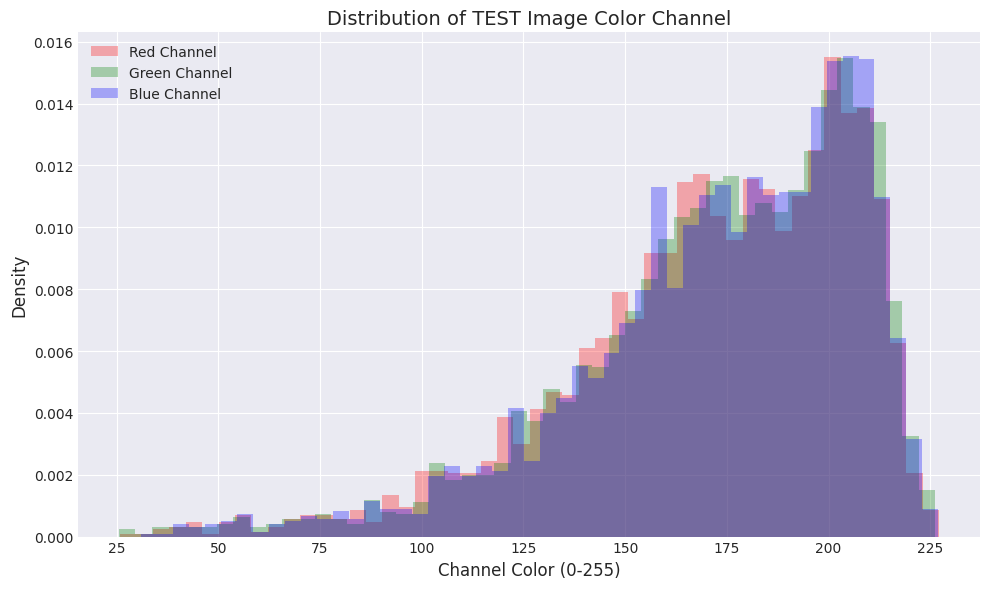

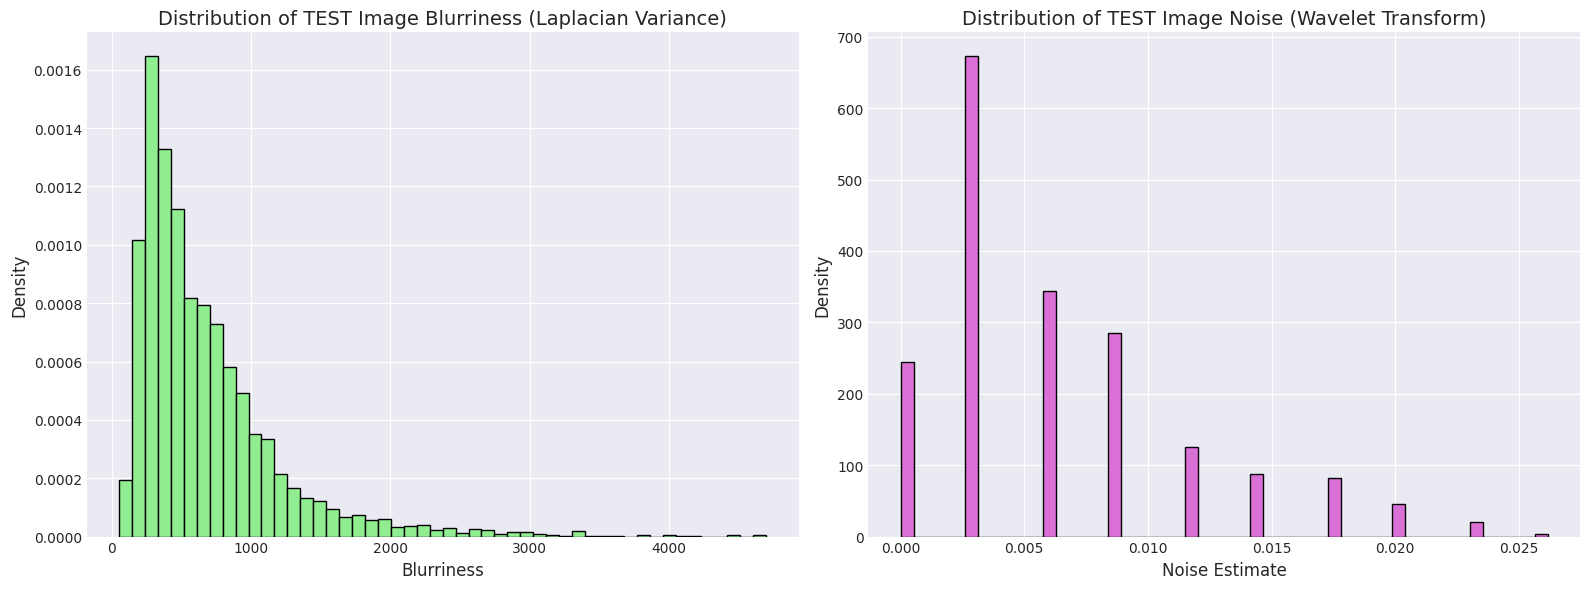

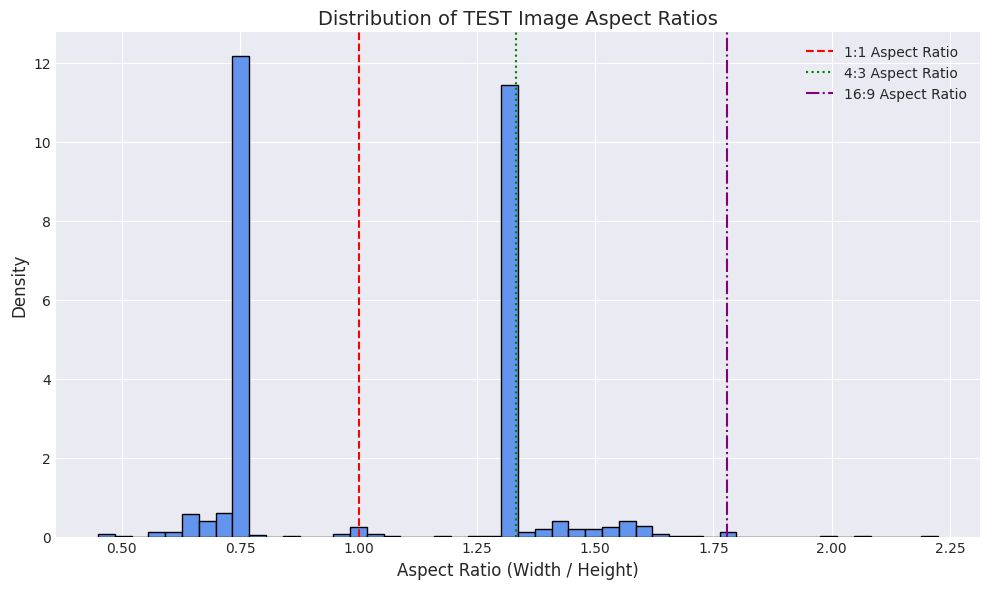

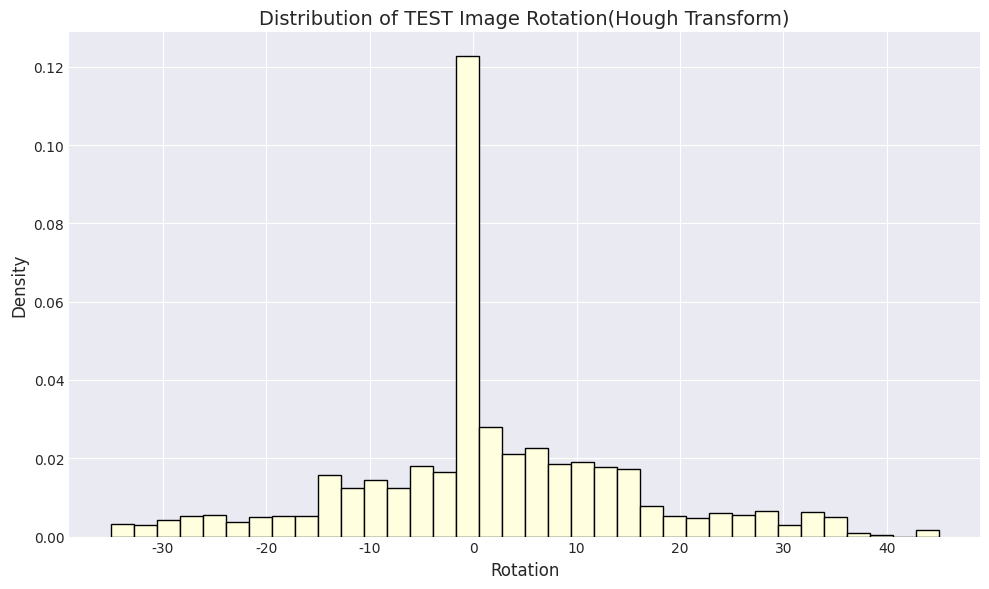

In [52]:
visualize_distributions(test_eda_df, data_type="TEST")

In [ ]:
train_df = pd.read_csv(os.path.join(data_dir,'train.csv'))
image_filenames = train_df['ID'].tolist()
data = []
for image_filename in tqdm(image_filenames):
    image_path = os.path.join(data_dir,'train',image_filename)
    if not os.path.exists(image_path):
        print(f"Warning: Image not found: {image_path}")
        continue
    try:
        brightness = calculate_brightness(image_path)
        contrast = calculate_contrast(image_path)
        color_channel = calculate_color_channel_distributions(image_path)
        red, green, blue = color_channel
        blurriness = calculate_blurriness(image_path)
        noise_estimate = calculate_noise(image_path)
        aspect_ratio = calculate_aspect_ratio(image_path)
        rotation_info = estimate_rotation_hough(image_path)

        data.append({
            'ID': image_filename,
            'brightness': brightness,
            'red': red,
            'green': green,
            'blue': blue,
            'contrast': contrast,
            'blurriness': blurriness,
            'noise_estimate': noise_estimate,
            'aspect_ratio': aspect_ratio,
            'rotation_info': rotation_info,
        })
    except Exception as e:
        print(f"Error processing {image_filename}: {e}")
train_eda_df = pd.DataFrame(data)

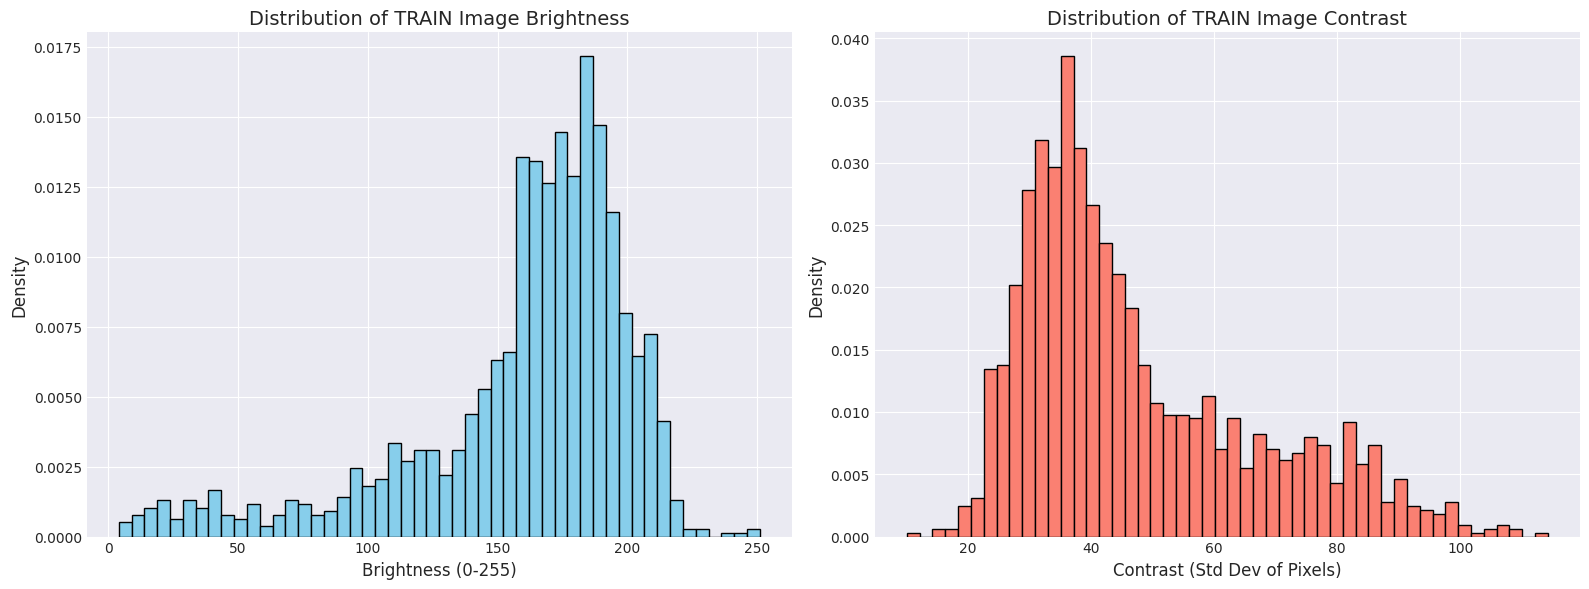

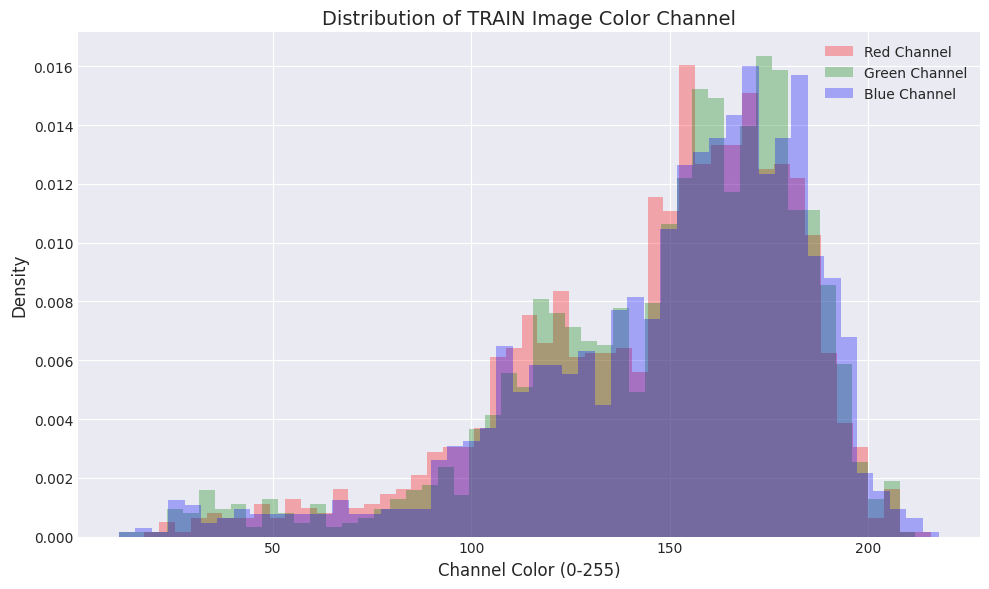

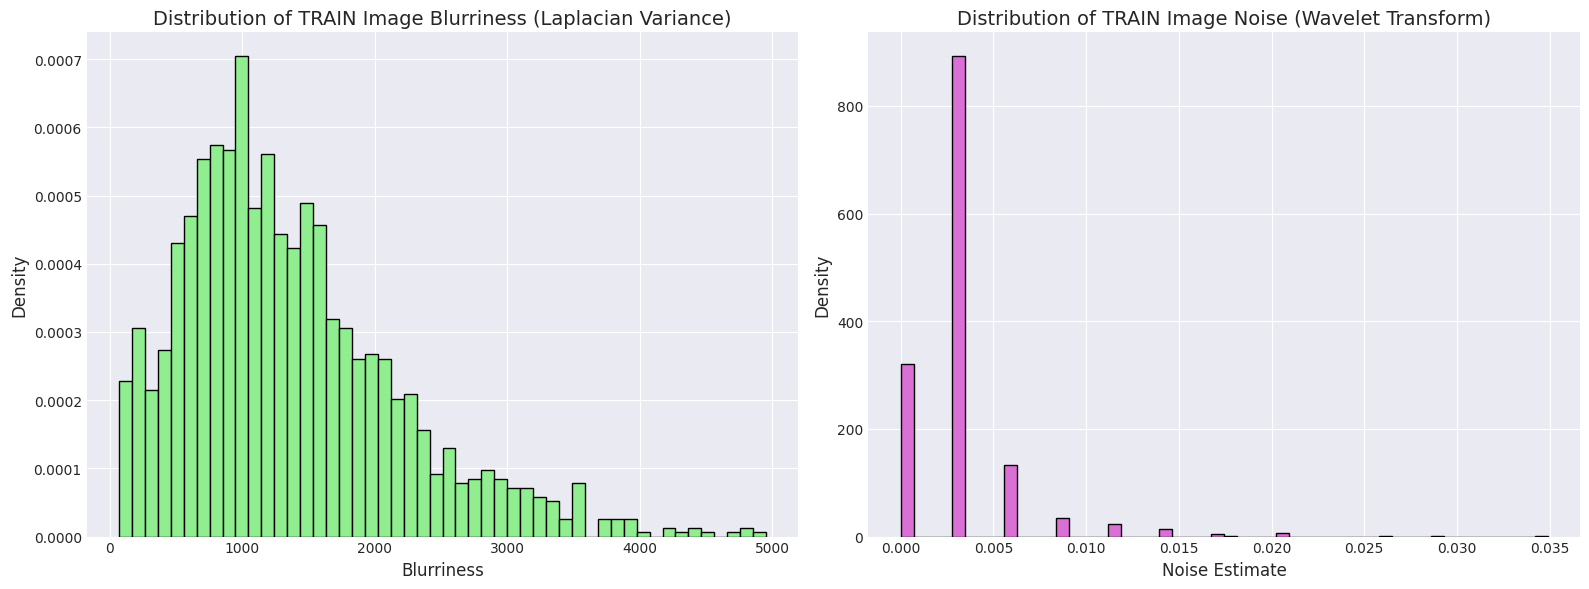

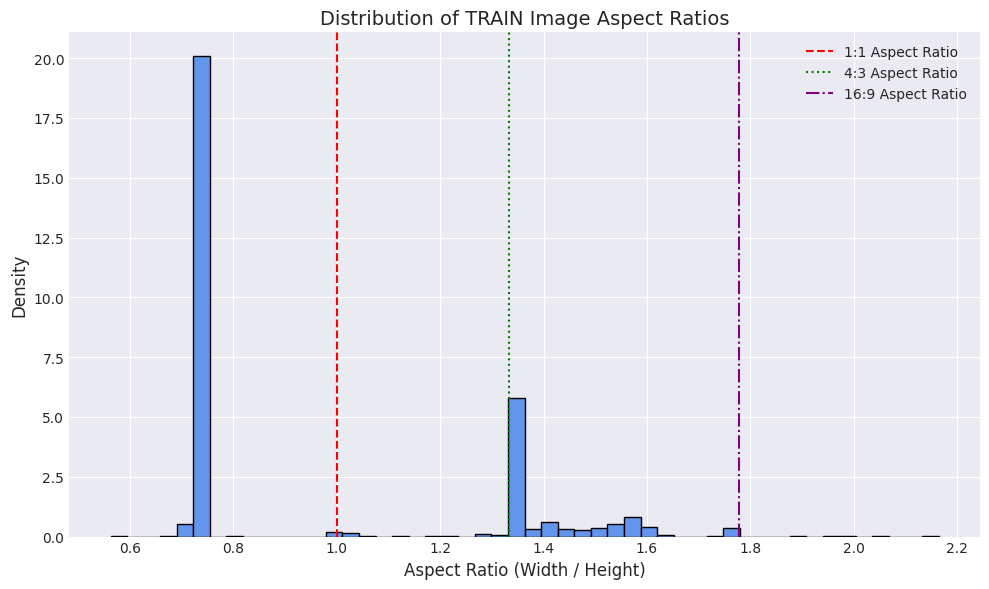

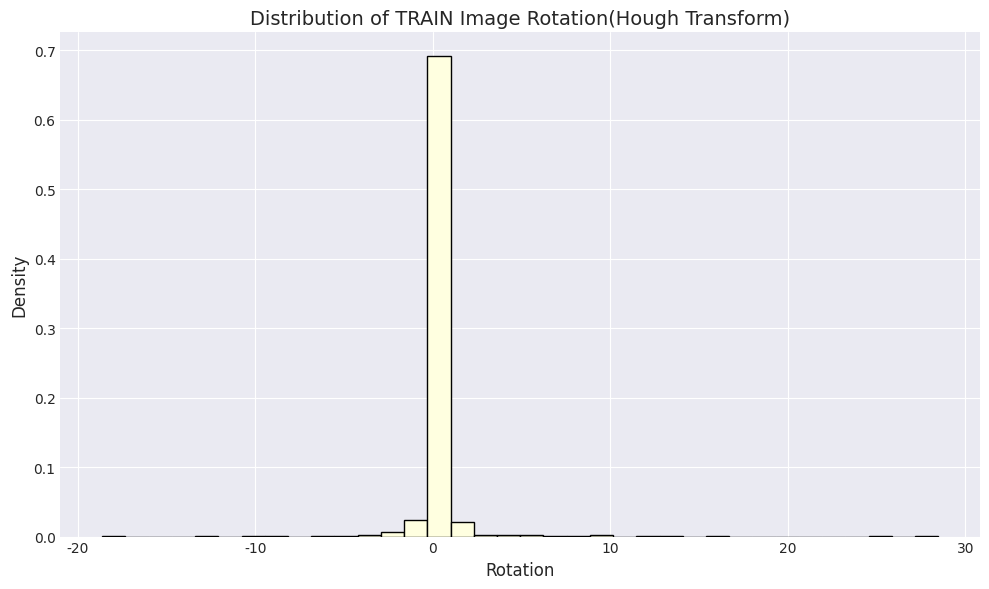

In [53]:
visualize_distributions(train_eda_df, data_type="TRAIN")

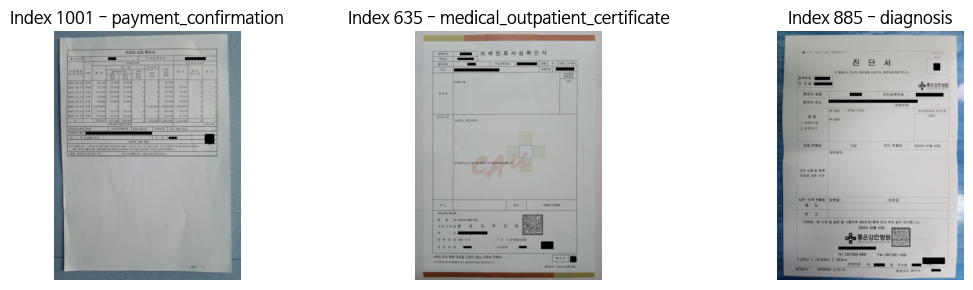

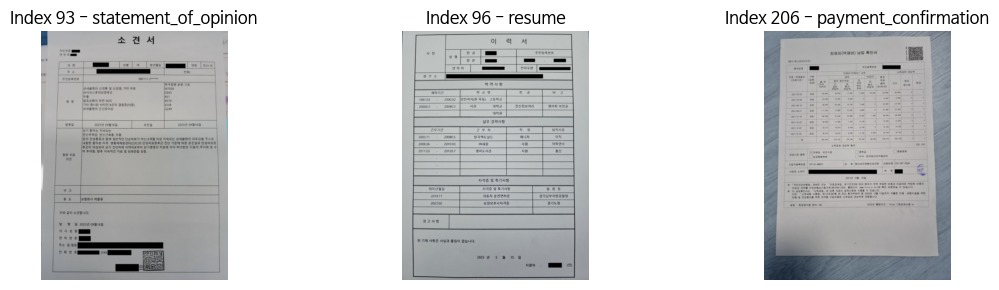

In [9]:
# visualize original image
# augmentation을 위한 transform 코드
train_transform = A.Compose([
    # 이미지 크기 조정
    A.SmallestMaxSize(max_size=CFG.image_size),
    # images normalization
    # A.Normalize(mean=CFG.norm_mean, std=CFG.norm_std),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])
train_dataset = ImageDataset(
    df=train_subset,
    path=os.path.join(data_dir,'train'),
    transform=train_transform
)
val_dataset = ImageDataset(
    df=val_subset,
    path=os.path.join(data_dir,'train'),
    transform=train_transform
)
visualize_by_index(train_dataset, indexs=train_idxs)
visualize_by_index(val_dataset, indexs=val_idxs)

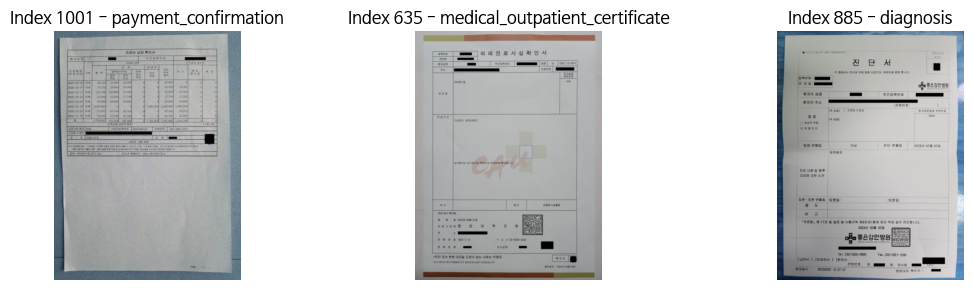

In [24]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=CFG.image_size),
        A.GaussNoise(std_range=(0.02, 0.2), p=0.8),
        # A.Normalize(mean=CFG.norm_mean, std=CFG.norm_mean),
        ToTensorV2(),
    ],
)
train_dataset = ImageDataset(
    df=train_subset,
    path=os.path.join(data_dir,'train'),
    transform=train_transform
)
visualize_by_index(train_dataset, indexs=train_idxs)

In [25]:
for idx in train_idxs:
    img_tensor, _ = train_dataset[idx]
    if img_tensor is None:
        raise ValueError("이미지를 불러오지 못했습니다.")

    # DWT (Discrete Wavelet Transform) 수행
    # 'db1' 웨이블렛 (Haar 웨이블렛), 1레벨 분해
    img_float_gray = img_tensor[0, :, :].numpy() / 255.0
    coeffs = pywt.dwt2(img_float_gray, 'db1')
    # 각 레벨의 계수는 (cA, (cH, cV, cD)) 튜플로 반환됩니다.
    # cD (Detail Diagonal) 계수는 대각선 방향의 고주파 성분을 나타내며, 노이즈에 민감합니다.
    cH, cV, cD = coeffs[1] # 고주파 성분 계수들을 가져옵니다.

    # 노이즈 표준 편차 추정을 위한 중앙값 절대 편차 (MAD) 사용
    # 노이즈가 가우시안 분포를 따른다고 가정할 때, MAD는 표준 편차의 좋은 추정치입니다.
    # sigma_noise = median(|cD|) / 0.6745 (가우시안 노이즈의 경우)
    mad_cD = np.median(np.abs(cD))
    noise_std_dev = mad_cD / 0.6745
    print(idx)
    print(noise_std_dev)

1001
0.055233360950013924
635
0.13662989287635002
885
0.031977208971060524
